In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from pushover import notify
from utils import makegif
from random import randint
import numpy as np

import IPython
from IPython.display import Image
from IPython.core.display import Image, display
import PIL

import piano_roll_utils
import librosa
import librosa.display

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
bs = 32 # batchsize

In [4]:
# Load Data

def load_img(img_path):
    img = PIL.Image.open(img_path)
    img = img.convert(mode="L")
#     npimg = np.array(img)/256.0
    return img
IMRANGE = 256 # uint8

dataset = datasets.ImageFolder(root='trainings/rolls_gray', transform=transforms.Compose([
    transforms.ToTensor(), 
    lambda x: x > 0,
    lambda x: x.type(torch.FloatTensor),
]), loader=load_img)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

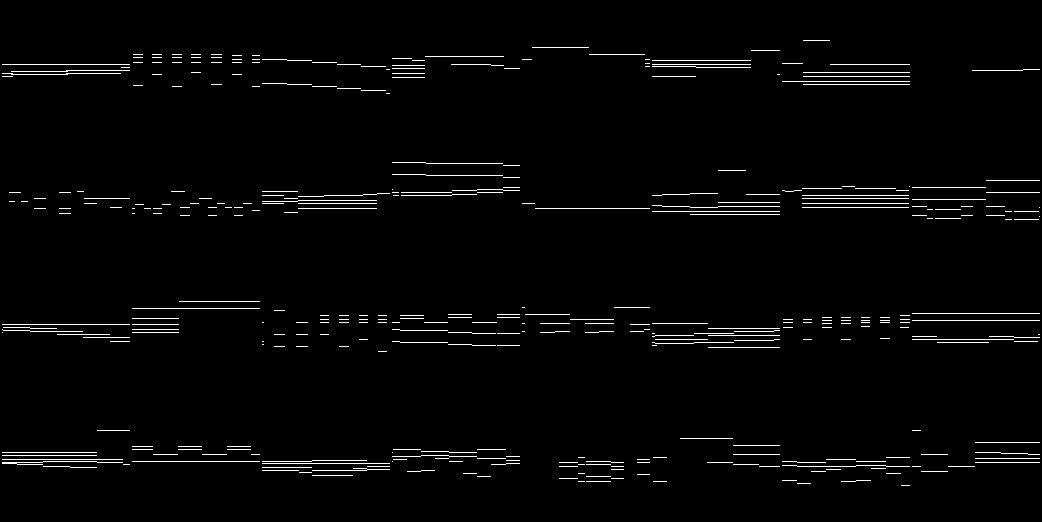

In [5]:
# Fixed input for debugging
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, 'tmp/real_image.png')

Image('tmp/real_image.png')

In [6]:
print(dataset[1][0].shape)
HSIZE = 2048 #9216 # 1024
ZDIM =  16

torch.Size([1, 128, 128])


In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class UnFlatten(nn.Module):
    def forward(self, input, size=HSIZE):
        return input.view(input.size(0), size, 1, 1)

In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels=1, h_dim=HSIZE, z_dim=ZDIM):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2), # -> [32, 32, 31, 31] 63
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # -> [32, 64, 14, 14] 31
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2), # -> [32, 128, 6, 6] 14
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2), # -> [32, 256, 2, 2] 6
            nn.ReLU(), 
            nn.Conv2d(256, 512, kernel_size=4, stride=2), # -> Null -> [32, 512, 2, 2] 
            nn.ReLU(), 
            Flatten() # -> [32, 1024]  -> [32, 2048]
            # [32, a, b, c] -> [32, abc]
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(), 
            nn.ConvTranspose2d(h_dim, 256 , kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
#         print("bottle: ",mu.shape, logvar.shape)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
#         print("======== Encode ========", x.shape)
        h = self.encoder(x)
#         print("enc(x): ", h.shape)
        z, mu, logvar = self.bottleneck(h)
#         print("z.shape: ", z.shape)
        return z, mu, logvar

    def decode(self, z):
#         print("======== Decode ========", z.shape)
        z = self.fc3(z)
#         print("fc3(z).shape: ", z.shape)
        z = self.decoder(z)
#         print("decode(fc3(z)).shape: ", z.shape)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
#         print(z.shape)
        z = self.decode(z)
#         print(z.shape, mu.shape, logvar.shape)
        return z, mu, logvar

In [10]:
image_channels = fixed_x.size(1)

In [11]:
image_channels

1

In [12]:
model = VAE(image_channels=image_channels).to(device)
model_version = "graybin_bce_d16-imgs_2297-epch_90-100"#"graybin_bce_d16-imgs_2297-epch_100"#"graybin_bce-imgs_2297-epch_60-100" 
model.load_state_dict(torch.load('models/cvae.' + model_version, map_location='cpu'))

In [13]:
def print_gt_zero_elem(matrix):
    print(get_elems(matrix))
    
def get_elems(matrix, thres=0.1):
    return matrix[matrix >= thres]

def get_piano_roll_from_prob(prob_img):
    bin_im = (prob_img>0.4).type(torch.FloatTensor)
    return bin_im * 64.0
#     return np.array((bin_im * 64.0).data.cpu()).astype(int)

def get_piano_roll_from_torch(torch):
    nimgs = torch.shape[0]
    curr = np.array(torch[0][0].data.cpu()).astype(int)
    for i in range(1, nimgs):
        curr = np.concatenate((curr, np.array(torch[i][0].data.cpu()).astype(int)), axis=1)
    return curr

## Random

In [14]:
fixed_x = dataset[randint(1, 100)][0].unsqueeze(0)
fixed_x2 = fixed_x.clone()

In [15]:
def compare(x):
    recon_x, _, _ = model(x)
    recon_x2 = recon_x.clone()
    recon_pass = (recon_x2>0.4).type(torch.FloatTensor) #* recon_x2
#     print("recon:", get_elems(recon_x, thres=0.01))
#     print("original:", get_elems(x, thres=0.01))
    return torch.cat([x * 64.0, recon_pass * 64.0]), recon_pass

In [16]:
for_play = np.array(fixed_x2[0][0]).astype(int) * 64
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

In [17]:
compare_x, recon_x = compare(fixed_x)

In [18]:
for_play = np.array(recon_x[0][0].data.cpu()) * 64
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play.astype(int) ,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

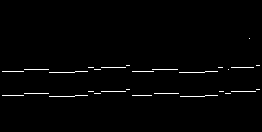

In [19]:
sample_filename = 'outputs/sample_image-{}.png'.format(model_version)
save_image(compare_x.data.cpu(), sample_filename)
display(Image(sample_filename, width=300, unconfined=True))

## Original

In [ ]:
save_image(fixed_x2 * 256, 'tmp/test.png', padding=0)
display(Image('tmp/test.png'))
z, mu, log_var = model.encode(fixed_x2)
print(z)

## Reconstruction

In [ ]:
decoded_val = model.decode(z)
tmp = get_piano_roll_from_prob(decoded_val)

tmp_filename = 'tmp/tmp.png'
save_image(tmp, tmp_filename)
display(Image(tmp_filename, width=300, unconfined=True))

In [ ]:
for_play = get_piano_roll_from_torch(tmp)
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play.astype(int) ,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

## Interpolation +0.1 values

In [ ]:
print(z)
inter = z.clone()

inter[0] += (torch.ones(16) * 0.1)
print(inter)
decoded_val = model.decode(inter)
tmp2 = get_piano_roll_from_prob(decoded_val)
tmp2 = torch.cat((tmp, tmp2), 0)
tmp_filename = 'tmp/tmp.png'
save_image(tmp2, tmp_filename)
display(Image(tmp_filename, width=300, unconfined=True))

In [ ]:
for_play = get_piano_roll_from_torch(tmp2)
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play.astype(int) ,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

## Interpolate from one roll to the other

In [ ]:
start = dataset[31][0].unsqueeze(0)
start_ = start.clone()
end = dataset[120][0].unsqueeze(0)
end_ = end.clone()
z_st, mu, log_var = model.encode(start)
z_en, mu, log_var = model.encode(end)
diff = z_en-z_st
timestamp = 10
print(z_st, z_en, diff)

In [ ]:
st_decoded = model.decode(z_st)
st_roll = get_piano_roll_from_prob(st_decoded)
st_f = 'tmp/st.png'
save_image(st_roll, st_f)
display(Image(st_f, width=300, unconfined=True))

en_decoded = model.decode(z_en)
en_roll = get_piano_roll_from_prob(en_decoded)
en_f = 'tmp/en.png'
save_image(en_roll, en_f)
display(Image(en_f, width=300, unconfined=True))

In [ ]:
z_curr = z_st.clone()
rolls = None
init = False
for t in range(timestamp):
    inc_val = diff/timestamp
    z_curr += (torch.ones(16) * inc_val)
    print(inter)
    piano_roll_prob = model.decode(z_curr)
    
    new_roll = get_piano_roll_from_prob(piano_roll_prob)
    if not init:
        rolls = new_roll
        init = True
    else:
        rolls = torch.cat((rolls, new_roll), 0)
interpolate_filename = 'outputs/interpolate.png'
save_image(rolls, interpolate_filename)
display(Image(interpolate_filename, height=300, unconfined=True))

In [ ]:
for_play = get_piano_roll_from_torch(rolls)
midi= piano_roll_utils.piano_roll_to_pretty_midi(for_play.astype(int) ,fs=50,program=11)
IPython.display.Audio(midi.fluidsynth(fs=44100),rate=44100)

# Next Steps

## Interfaces (2 Tabs)

### step 1: 32 Dim interface:
- 32 sliders -> play music

### step 2: 2 Dim (Hilbert) interface
- 2 sliders -> play music

## Web Interface
In a web-interface: 
- Backend : Flask
- frontend: Bootstrap 

## Suggested tools
TensorBoardX
    = visualize ML training
TensorBoardMusic

## Deadline
- 16 May (Abstract submission) 
- 23 May (Final Submission)